In [1]:
# 분별 모델
# 표정을보고 상대의 감정을 읽는다 - SVM, 다층퍼셉트론,컨볼류션 신경망, LSTM, 강화학습

In [2]:
# 생성모델
# GAN 

In [3]:
# 확률생성 모델을 MNIST 필기 숫자에 적용
import numpy as np
from tensorflow.keras.datasets import mnist

In [4]:
# 0만 추출
(x_train,y_train),(x_test,y_test) =  mnist.load_data()

In [71]:
# X = x_train[y_train==0]
X=x_train[np.isin(y_train,[0])]

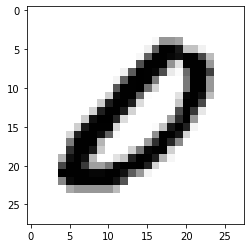

In [72]:
import matplotlib.pyplot as plt
plt.imshow(X[-2],cmap='gray_r')

In [84]:
import numpy as np
from tensorflow.keras.datasets import mnist

# MNIST 데이터를 읽고 0 패턴만 추출
(x_train,y_train),(x_test,y_test)=mnist.load_data()
X=x_train[np.isin(y_train,[0])]

# 화소 수준의 확률 생성 모델 구축
P=np.zeros((28,28,256))
for k in range(X.shape[0]):
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            P[i][j][X[k][i][j]]+=1
P=P/X.shape[0]

# 확률 생성 모델을 이용하여 20개 샘플을 생성
Xnew=np.zeros((20,28,28))
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c]=np.random.choice(range(256),p=P[r][c])

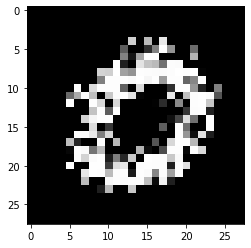

In [87]:
plt.imshow(Xnew[0],cmap='gray')